In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import inspect
import os
import sys
import time

onp.random.seed(3452453)

In [2]:
from bnpmodeling_runjingdev import result_loading_utils

from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_optimization_lib as reg_optim_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

from bnpreg_runjingdev.genomics_data_utils import spline_bases_lib

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
import regression_plotting_utils

# Sample data

In [4]:
###############
# Draw data
###############

# define timepoints
n_rep = 3 # replcates per time points
n_unique_timepoints = 14 # number of timepoints

timepoints = np.array([[i, ] * n_rep for i in range(n_unique_timepoints)]).flatten()

# get regressors
regressors = spline_bases_lib.get_genomics_spline_basis(timepoints,
                                                        df=7, 
                                                        degree=3)

dim_reg = regressors.shape[-1]

# draw cluster memberships
true_k = 3
n_obs = 1000
true_z = jax.random.categorical(key = jax.random.PRNGKey(26), 
                                # decreasing cluster size
                                logits = np.array([-i * 0.5 for i in range(true_k)]), 
                                shape = (n_obs, ))
true_z_onehot = jax.nn.one_hot(true_z, true_k)

# draw true regression coefficients
beta_var = 10.
true_beta = jax.random.normal(key = jax.random.PRNGKey(901), 
                              shape = (true_k, dim_reg)) * np.sqrt(beta_var)

# draw random shifts
shift_var = 10.
true_shifts = jax.random.normal(key = jax.random.PRNGKey(901), 
                              shape = (n_obs,)) * np.sqrt(shift_var)

# sample individuals
beta_n = np.dot(true_z_onehot, true_beta)

true_data_info = 5.

noise = jax.random.normal(key = jax.random.PRNGKey(3453), 
                          shape = (n_obs, len(timepoints))) * 1 / np.sqrt(true_data_info)

y = np.dot(beta_n, regressors.transpose()) + noise + true_shifts[:, None]


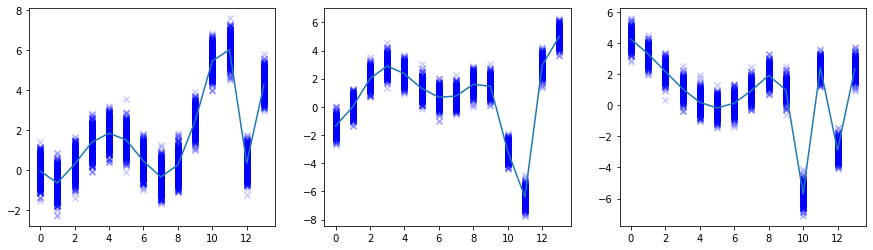

In [5]:
f, axarr = plt.subplots(1, 3, figsize=(15,4))

for k in range(true_k): 
    
    axarr[k].plot(timepoints,
                  np.dot(true_beta[k], regressors.transpose()))
    
    for n in range(n_obs): 
        if true_z[n] != k: 
            continue 
        
        axarr[k].scatter(timepoints, y[n] - true_shifts[n], marker = 'x', color = 'blue', alpha = 0.2)

# Prior parameters

In [6]:
prior_params_dict, vb_params_paragami = regression_mixture_lib.get_default_prior_params()

In [7]:
prior_params_dict['dp_prior_alpha'] = 6.0

In [8]:
prior_params_dict

{'dp_prior_alpha': 6.0,
 'prior_centroid_mean': DeviceArray([0.], dtype=float64),
 'prior_centroid_info': DeviceArray([0.1], dtype=float64),
 'prior_shift_mean': DeviceArray([0.], dtype=float64),
 'prior_shift_info': DeviceArray([0.1], dtype=float64),
 'prior_data_info_shape': DeviceArray([10.], dtype=float64),
 'prior_data_info_scale': DeviceArray([0.1], dtype=float64)}

# VB parameters

In [9]:
k_approx = 15
vb_params_dict, vb_params_paragami = regression_mixture_lib.get_vb_params_paragami_object(dim_reg, k_approx)

In [10]:
print(vb_params_paragami)

OrderedDict:
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (14,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (14,) (lb=0.0001, ub=inf)
	[centroids] = NumericArrayPattern (15, 10) (lb=-inf, ub=inf)
	[data_info] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


### Gauss hermite 

In [11]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

# Optimize

In [12]:
vb_opt_dict, vb_opt, ez_opt, out, optim_time = \
    reg_optim_lib.optimize_regression_mixture(y, regressors, 
                                              vb_params_dict,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights, 
                                              run_newton=True)
print(out.fun)

compiling objective and derivatives ... 
done. Compile time: 10.526sec
Running L-BFGS-B ...
L-BFGS-B time: 6.440sec
Running trust-ncg ... 
Newton time: 3.029sec
Optimization terminated successfully.
done. 
-8148.0520326803335


In [13]:
# get estimated shifts
est_shifts = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(y, regressors, vb_opt_dict, prior_params_dict, gh_loc, gh_weights)[2]
which_col = ez_opt == ez_opt.max(1)[:, None] # one-hot encoding of estimated memberships
est_shifts = (est_shifts * which_col).sum(1) # extract shifts 
print(np.abs(est_shifts - true_shifts).max()) #check equal

0.2957342153041005


In [14]:
# get only the clusters present in the posterior
which_clusters = np.unique(ez_opt.argmax(1))

# estimated parameters
est_beta = vb_opt_dict['centroids'][which_clusters, :]
est_ez = ez_opt[:, which_clusters]

In [16]:
from scipy.optimize import linear_sum_assignment

In [17]:
# find minimizing permutation
# of each est cluster to true cluster

diffs = ((est_beta[None, :, :] - \
          true_beta[:, None, :])**2).sum(-1)
        
perm = linear_sum_assignment(diffs)[1]

In [18]:
centroid_diff = est_beta[perm] - true_beta

In [19]:
np.abs(centroid_diff).max()

DeviceArray(0.1304549, dtype=float64)

In [20]:
est_z_permed = est_ez[:, perm].argmax(1)

In [21]:
(est_z_permed == true_z).mean()

DeviceArray(1., dtype=float64)

In [22]:
est_weights = reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)
est_weights = est_weights[which_clusters][perm]

In [26]:
est_weights - true_z_onehot.mean(0)

DeviceArray([-0.00385963, -0.00126218, -0.00369423], dtype=float64)

DeviceArray([0.521, 0.284, 0.195], dtype=float64)

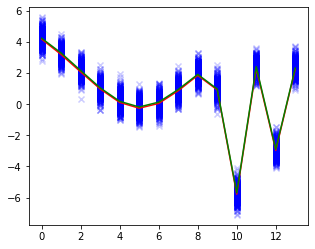

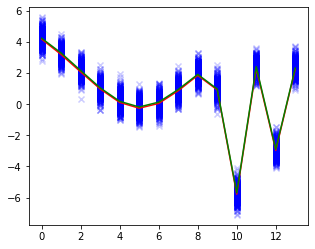

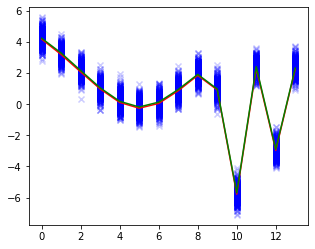

In [25]:
for i in range(est_ez.shape[1]): 
        
    f, axarr = plt.subplots(1, 1, figsize=(5,4))
    
    axarr.plot(timepoints,
                  np.dot(est_beta[perm[k]], regressors.transpose()), 
               color = 'red')
    
    axarr.plot(timepoints,
                  np.dot(true_beta[k], regressors.transpose()), 
               color = 'green')
    
    for n in range(n_obs): 
        if est_z_permed[n] != k: 
            continue 
        
        axarr.scatter(timepoints, y[n] - true_shifts[n], marker = 'x', color = 'blue', alpha = 0.2)